# Introduction to Convolutional Neural Networks (CNNs) in TensorFlow

### Representing images digitally

While convolutional neural networks (CNNs) see a wide variety of uses, they were originally designed for images, and CNNs are still most commonly used for vision-related tasks.
For today, we'll primarily be focusing on CNNs used on images.
Before we dive into convolutions and neural networks, it's worth prefacing with how images are represented by a computer, as this understanding will inform some of our design choices.

In yesterday's lecture, we saw an example of a digitized MNIST handwritten digit.
Specifically, we represent it as an $H \times W$ table, with the value of each element storing the intensity of the corresponding pixel.

<img src="Figures/mnist_digital.PNG" alt="mnist_digital" style="width: 600px;"/>

With a 2D representation as above, we for the most part can only efficiently represent grayscale images.
What if we want color?
There are many schemes for color, but one of the most common ones is the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model).
In such a system, we store 3 tables of pixel intensities (each called a *channel*), one each for the colors red, green, and blue (hence RGB), resulting in an $H \times W \times 3$ tensor.
Pixel values for a particular channel indicate how much of the corresponding color the image has at a particular location.

Let's load an image and see this:

In [1]:
# You may need to install matplotlib and imageio first:
#
# pip install matplotlib
# pip install imageio

!pip install imageio
!pip install matplotlib

tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorboard 1.8.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.


tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorboard 1.8.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.


(620, 1175, 3)


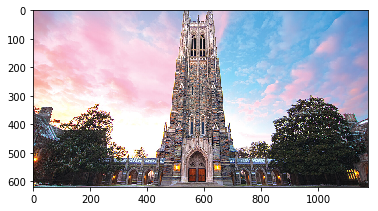

In [2]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Read image
im = imageio.imread("./Figures/chapel.jpg")
print(im.shape)
plt.imshow(im)

We can see that the image we loaded has height and width of $620 \times 1175$, with 3 channels corresponding to RGB.

We can easily slice out and view individual color channels:

(620, 1175)


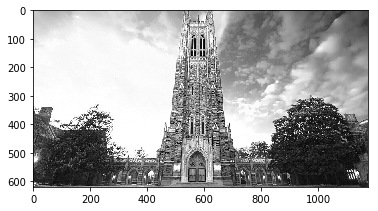

In [3]:
# Red channel
im_red = im[:,:,0]
print(im_red.shape)
plt.imshow(im_red, cmap='gray')

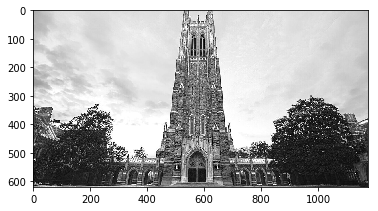

In [4]:
# Blue channel
im_blue = im[:,:,2]
plt.imshow(im_blue, cmap='gray')

While we have so far considered only 3 channel RGB images, there are many settings in which we may consider a different number of channels.
For example, [hyperspectral imaging](https://en.wikipedia.org/wiki/Hyperspectral_imaging) uses a wide range of the electromagnetic spectrum to characterize a scene.
Such modalities may have hundreds of channels or more.
Additionally, we'll soon see that certain intermediate represenations in a CNN can be considered images with many channels.
However, we'll focus much of today's discussion to 1 channel grayscale and 3 channel RGB images as our inputs, as is most commonly the case in computer vision.

### Convolutions
Convolutional neural networks are a class of neural networks that have convolutional layers.
CNNs are particularly effective for data that have spatial structures and correlations (e.g. images).
We'll focus on CNNs applied to images in this tutorial.
Recall from yesterday, a multilayer perceptron (MLP) is entirely composed of fully connected layers, which are each a matrix multiply operation (and addition of a bias) followed by a non-linearity (e.g. sigmoid, ReLU). 
A convolutional layer is similar, except the matrix multiply operation is replaced with a convolution operation (in practice a cross-correlation). 
Note that a CNN need not be entirely composed of convolutional layers; in fact, many popular CNN architectures end in fully connected layers.

As before, since we're building neural networks, let's start by loading TensorFlow. We'll find NumPy useful as well, so we'll also import that here.

In [5]:
import tensorflow as tf
import numpy as np

C:\Users\kevin_000\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Review: Fully connected layer
In a fully connected layer, the input $x \in \mathbb R^{M \times C_{in}}$ is a vector (or, rather a batch of vectors), where $M$ is the minibatch size and $C_{in}$ is the dimensionality of the input. 
We first matrix multiply the input $x$ by a weight matrix $W$.
This weight matrix has dimensions $W \in \mathbb R^{C_{in} \times C_{out}}$, where $C_{out}$ is the number of output units.
We then add a bias for each output, which we do by adding $b \in \mathbb{R}^{C_{out}}$.
The output $y \in \mathbb{R}^{M \times C_{out}}$ of the fully connected layer then:

\begin{align*}
y = \text{ReLU}(x W + b)
\end{align*}

Remember, the values of $W$ and $b$ are variables that we are trying to learn for our model. 
Below we have a visualization of what the matrix operation looks like (bias term and activation function omitted).

<img src="Figures/fully_connected.png" alt="fully_connected" style="width: 700px;"/>
<center>Figure adapted from *[A Multithreaded CGRA for Convolutional Neural Network Processing](https://www.researchgate.net/publication/318025612_A_Multithreaded_CGRA_for_Convolutional_Neural_Network_Processing?_sg=MwYs2n43RZGhaLyzNQwxOhIkb4VfQVEavAttULBtZr3Ax4vsebFlihBGwom6soQAHqEb5kwS2Q)*</center>

In [6]:
# Create flat input vector
x_fc = tf.placeholder(tf.float32, [None, 784])

# Create weight matrix variable
W = tf.Variable(tf.truncated_normal([784,10], stddev=0.1))

# Create bias variable
b = tf.Variable(tf.zeros([10]))

# Apply fully connected layer
y_preact = tf.matmul(x_fc, W) + b
y = tf.nn.relu(y_preact)

# Print input/output shape
print(x_fc.shape)
print(y.shape)

(?, 784)
(?, 10)


#### Convolutional layer
In a convolutional layer, we convolve with a convolutional kernel (aka filter), which we also call $W$. 
Unlike the input of a fully connected layer, which is $x \in \mathbb R^{M\times C_{in}}$, the dimensionality of an image input is 4D: $x \in \mathbb R^{M \times H_{in} \times W_{in} \times C_{in}}$.
Another difference is that also unlike the 2-D weight matrix for fully connected layers, the kernel is 4-D with dimensions $W \in \mathbb R^{H_K \times W_K \times C_{in} \times C_{out}}$, where $H_K$ and $W_K$ are the kernel height and weight, respectively.
Common choices for $H_K$ and $W_K$ are $H_K = W_K = 3$ or $H_K = W_K = 5$.
Convolving the input with the kernel and adding a bias then gives an output $y \in \mathbb R^{M \times H_{in} \times W_{in} \times C_{out}}$:

\begin{align*}
y = \text{ReLU}(x*W + b)
\end{align*}

In the context of CNNs, the output $y$ is often referred to as feature maps. Again, the goal is to learn $W$ and $b$ for our model.

If you're having trouble visualizing this operation in 4D, it's easier to think about for a single member of the minibatch, one convolutional kernel at a time. 
Consider a stack of $C_{out}$ kernels, each of which are 3D ($H_K \times W_K \times C_{in}$). 
This 3D volume is then slid across the input (which is also 3D: $H_{in} \times W_{in} \times C_{in}$) in the two spatial dimensions (along $H_{in}$ and $W_{in}$). 
The outputs of the multiplication of the kernel and the input at every location creates a single feature map that is $H_{in} \times W_{in}$ (assuming no pooling or striding; we'll get to that later). 
Stacking the feature maps generated by each kernel gives the 3D output $H_{in} \times W_{in} \times C_{out}$.
Repeat the process for all $M$ inputs, and we get a 4D output $M \times H_{in} \times W_{in} \times C_{out}$.

<img src="Figures/single_W_conv.png" alt="single_W_conv" style="width: 400px;"/>
<center>Figure from *[Convolutional Neural Network. Brilliant.org.](https://brilliant.org/wiki/convolutional-neural-network/)*</center>


A couple more things to consider for convolutions:
- An additional argument for the convolution is the *stride*, which controls the spacing at which we multiply the input with the kernel during the convolution operation. 
The convolutional operator, from its signal processing roots, by default considers a stride length of 1 in all dimensions, but in some situations we would like to consider strides more than 1 (or even less than 1). 
More on this later.
- In the context of signal processing, convolutions usually result in outputs that are larger than the input size, which results from when the kernel "hangs off the edge" of the input on both sides. 
This might not always be desirable.
We can control this by controlling the padding of the input.
Typically, we use "SAME" padding, which ensures the output has the same spatial dimensions as the input (assuming stride of 1); this makes it easier for us to keep track of what the size of our model is.

Let's implement this convolution operator in code.

In [7]:
# Create image input placeholder
x_cnn = tf.placeholder(tf.float32, [None, 28, 28, 1])

# Create convolutional kernel variable
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 16], stddev=0.1))

# Create bias variable
b1 = tf.Variable(tf.zeros([16]))

# Apply convolutional layer
conv1_preact = tf.nn.conv2d(x_cnn, W1, strides=[1, 1, 1, 1], padding="SAME") + b1
conv1 = tf.nn.relu(conv1_preact)

# Print input/output shape
print(x_cnn.shape)
print(conv1.shape)

(?, 28, 28, 1)
(?, 28, 28, 16)


Just like in a MLP, we can stack multiple of these convolutional layers. 
In the *Representing Images Digitally* section, we briefly mentioned considering images with channels more than 3.
Observe that the input to the second layer (i.e. the output of the first layer) can be viewed as an "image" with $C_{out}$ channels.
Instead of each channel representing a color content though, each channel effectively represents how much the original input image activated a particular convolutional kernel.
Given $C_{out}$ kernels that are each $H_K \times W_K \times C_{in}$, this results in $C_{out}$ channels for the output of the convolution.

Note that we need to change the dimensions of the convolutional kernel such that its input channels matches the number of output channels of the previous layer.:

In [8]:
# 2nd layer variables
W2 = tf.Variable(tf.truncated_normal([5, 5, 16, 32], stddev=0.1))
b2 = tf.Variable(tf.zeros([32]))

# Apply 2nd convolutional layer
conv2 = tf.nn.relu(tf.nn.conv2d(conv1, W2, strides=[1,1,1,1], padding="SAME") + b2)

# Print output shape
print(conv2.shape)

(?, 28, 28, 32)


In fact, we typically perform these convolution operations many times. Popular architectures for image analysis today are commonly 100+ layers.

### Reshaping

You'll commonly finding yourself needing to reshape tensors while building CNNs.
The TensorFlow function for doing so is `tf.reshape()`. 
Anyone familiar with `numpy` will find it very similar to `np.reshape()`.
Importantly, it must be possible to rearrange the input into the shape of the output (ie the number of values must be the same).
You can optionally leave out one of the dimensions by using a `-1`, which tells `reshape` to infer the missing dimension.

In [9]:
M = tf.constant(np.zeros([4,3]), tf.float32)

M2 = tf.reshape(M, [1,1,12])
M3 = tf.reshape(M, [2,1,2,3])
M4 = tf.reshape(M, [-1,2,3])
M5 = tf.reshape(M, [-1])

To get an idea of why reshaping is need in a CNN, let's look at a diagram of a simple CNN.

<img src="Figures/mnist_cnn_ex.png" alt="mnist_cnn_ex" style="width: 700px;"/>
<center>Figure from [*Getting started with PyTorch for Deep Learning (Part 3: Neural Network basics). Code to Light.*](https://codetolight.wordpress.com/2017/11/29/getting-started-with-pytorch-for-deep-learning-part-3-neural-network-basics/)</center>

First of all, the CNN expects a 4D input, with the dimensions corresponding to `[batch, height, width, channel]`.
Your data probably won't come in this format, so you'll likely have to reshape it yourself.
For example, remember MNIST comes in flat vectors (`[,784]`). 

In [10]:
# Reshape flat input image into a 4D batched image input
x_flat = tf.placeholder(tf.float32, [None, 784])
x_reshaped = tf.reshape(x_flat, [-1, 28, 28, 1])

# Print input shape
print(x_reshaped.shape)

(?, 28, 28, 1)


CNN architectures also commonly contain fully connected layers or a softmax, as we're often interested in classification.
Both of these expect 2D inputs with dimensions `[batch, dim]`, so you have to "flatten" a CNN's 4D output to 2D.
For example, to flatten the convolutional feature maps we created earlier:

In [11]:
# Flatten convolutional feature maps into a vector
h_flat = tf.reshape(conv2, [-1, 28*28*32])

# Print output shape
print(h_flat.shape)

(?, 25088)


### Pooling and striding

Almost all CNN architectures incorporate either pooling or striding. This is done for a number of reasons, including:
- Dimensionality reduction: pooling and striding operations reduces computational complexity by shrinking the number of values passed to the next layer.
For example, a 2x2 maxpool reduces the size of the feature maps by a factor of 4.
- Translational invariance: Oftentimes in computer vision, it is desirable feature of our model that shifting the input by a few pixels doesn't change the output. Pooling and striding reduces sensitivity to exact pixel locations.
- Increasing receptive field: by summarizing a window with a single value, subsequent convolutional kernels are seeing a wider swath of the original input image. For example, a max pool on some input followed by a 3x3 convolution results in a kernel "seeing" 6x6 instead of 3x3.

#### Pooling
The two most common forms of pooling are max pooling and average pooling. 
Both reduce values within a window to a single value, on a per feature map basis.
Max pooling takes the maximum value of the window as the output value; average pooling takes the mean.

<img src="Figures/avg_vs_max_pool.JPG" alt="avg_vs_max" style="width: 400px;"/>
<center>Figure from [*A deeper understanding of NNets (Part 1) — CNNs. Towards Data Science.*](https://towardsdatascience.com/a-deeper-understanding-of-nnets-part-1-cnns-263a6e3ac61)</center>

In [12]:
# Taking the output we've been working with so far, first print its current size
print("Shape of conv2 feature maps before pooling: {0}".format(conv2.shape))

# Max pool and then print new shape
max_pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
print("Shape of conv2 feature maps after max pooling: {0}".format(max_pool2.shape))

# Average pool and then print new shape
avg_pool2 = tf.nn.avg_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
print("Shape of conv2 feature maps after avg pooling: {0}".format(avg_pool2.shape))

Shape of conv2 feature maps before pooling: (?, 28, 28, 32)
Shape of conv2 feature maps after max pooling: (?, 14, 14, 32)
Shape of conv2 feature maps after avg pooling: (?, 14, 14, 32)


We can confirm that the two types of pooling behave how we'd expect:

In [13]:
# Recreate values in pooling figure and make it 4D
feature_map_fig = tf.constant(np.array([[1,3,2,4],
                                        [1,3,2,4],
                                        [5,7,6,8],
                                        [5,7,6,8]]), dtype=tf.float32)
fmap_fig = tf.reshape(feature_map_fig, [1,4,4,1])
print("Feature map shape pre-pooling: {0}".format(fmap_fig.shape))

# Maxpool
max_pool_fig = tf.nn.max_pool(fmap_fig, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
print("Feature map shape post-max pooling: ")
max_pool_fig = tf.reshape(max_pool_fig, [2,2])

# Avgpool
avg_pool_fig = tf.nn.avg_pool(fmap_fig, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
print("Feature map shape post-avg pooling: ")
avg_pool_fig = tf.reshape(avg_pool_fig, [2,2])

# Check that values match figure
with tf.Session() as sess:
    print("\nMax pool")
    print(sess.run(max_pool_fig))
    
    print("\nAvg pool")
    print(sess.run(avg_pool_fig))

Feature map shape pre-pooling: (1, 4, 4, 1)
Feature map shape post-max pooling: 
Feature map shape post-avg pooling: 

Max pool
[[3. 4.]
 [7. 8.]]

Avg pool
[[2. 3.]
 [6. 7.]]


#### Striding
One might expect that pixels in an image have high correlation with neighboring pixels, so we can save computation by skipping positions while sliding the convolutional kernel. 
By default, a CNN slides across the input one pixel at a time, which we call a stride of 1.
By instead striding by 2, we skip calculating 75% of the values of the output feature map, which yields a feature map that's half the size in each spatial direction.
Note, while pooling is an operation done after the convolution, striding is part of the convolution operation itself.

In [14]:
# Since striding is part of the convolution operation, we'll start with the feature maps before the 2nd convolution
print("Shape of conv1 feature maps: {0}".format(conv1.shape))

# Apply 2nd convolutional layer, with striding of 2
conv2_strided = tf.nn.relu(tf.nn.conv2d(conv1, W2, strides=[1,2,2,1], padding="SAME") + b2)

# Print output shape
print("Shape of conv2 feature maps with stride of 2: {0}".format(conv2_strided.shape))

Shape of conv1 feature maps: (?, 28, 28, 16)
Shape of conv2 feature maps with stride of 2: (?, 14, 14, 32)


In [15]:
# Clear previous ops from the graph
tf.reset_default_graph()

### Higher level APIs

So far, we've primarily been building neural networks with the TensorFlow Core API, the lowest level of abstraction.
This gives the user the finest amount of control over the TensorFlow graph, as well as providing the clearest picture of what's going on under the hood.
This can be important as you're learning concepts and the various frameworks, and sometimes the flexibility is necessary if you're trying to build something outside of the standard models.

However, most of the time, we do find ourselves repeating the same fairly standard lines of code, which can slow us down. 
Worse, it clutters up our code unnecessarily and introduces room for bugs and typos.
And finally, as researchers or engineers, we would like to spend most of our time thinking on the highest levels of abstractions: I want to add a convolution layer here, then a fully connected there, etc.
Having to code all the small details are distractions that can detract from our ability to translate ideas into code.

For this reason, several people have built high level APIs on top of TensorFlow, with Keras, tf.layers, and TF-Slim* being notable examples.
We'll briefly touch on TF-Slim and tf.layers here, but we encourage you to look into the options and decide which best suit your needs and preferences.

**Note: TF-Slim is no longer officially supported by the TensorFlow team*

#### VGG-16
To illustrate what I mean about levels of abstraction, let's consider [VGG-16](https://arxiv.org/abs/1409.1556). This style of architecture came in 2nd during the 2014 ImageNet Large Scale Visual Recognition Challenge and is famous for its simplicity and depth. The model looks like this:

<img src="Figures/vgg16.png" alt="vgg16" style="width: 600px;"/>
<center>Figure from [*Deep CNN and Weak Supervision Learning for visual recognition*](https://blog.heuritech.com/2016/02/29/a-brief-report-of-the-heuritech-deep-learning-meetup-5/)</center>

The architecture is pretty straight-forward: simply stack multiple 3x3 convolutional filters one after another, interleave with 2x2 maxpools, double the number of convolutional filters after each maxpool, flatten, and finish with fully connected layers. A couple ideas behind this model:

- Instead of using larger filters, VGG notes that the receptive field of two stacked layers of 3x3 filters is 5x5, and with 3 layers, 7x7. Using 3x3's allows VGG to insert additional non-linearities and requires fewer weight parameters to learn.

- Doubling the width of the network every time the features are spatially downsampled (maxpooled) gives the model more representational capacity while achieving spatial compression.

First, let's create our input and output placeholders:

In [16]:
images = tf.placeholder(tf.float32, [None, 224, 224, 3])
labels = tf.placeholder(tf.float32, [None, 1000])

In code, setting up the computation graph for just feedforwad part of VGG-16 with the TensorFlow Core API is kind of a lot:

In [17]:
# Define the model
with tf.name_scope('conv1_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv1 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv1_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv1 = tf.nn.relu(bias, name=scope)
    
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
    
with tf.name_scope('conv2_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv2 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv2_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv2 = tf.nn.relu(bias, name=scope)
    
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')
    
with tf.name_scope('conv3_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv3 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv3_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv3, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv3 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv3_3') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv3, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv3 = tf.nn.relu(bias, name=scope)
    
pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool3')
    
with tf.name_scope('conv4_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv4 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv4_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv4, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv4 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv4_3') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv4, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv4 = tf.nn.relu(bias, name=scope)
    
pool4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool4')

with tf.name_scope('conv5_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool4, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv5 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv5_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv5, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv5 = tf.nn.relu(bias, name=scope)
    
with tf.name_scope('conv5_3') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv5, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv5 = tf.nn.relu(bias, name=scope)
    
pool5 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool5')
    
with tf.name_scope('fc_6') as scope:
    flat = tf.reshape(pool5, [-1, 7*7*512])
    weights = tf.Variable(tf.truncated_normal([7*7*512, 4096], dtype=tf.float32, stddev=1e-1), name='weights')
    mat = tf.matmul(flat, weights)
    biases = tf.Variable(tf.constant(0.0, shape=[4096], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(mat, biases)
    fc6 = tf.nn.relu(bias, name=scope)
    fc6_drop = tf.nn.dropout(fc6, keep_prob=0.5, name='dropout')

with tf.name_scope('fc_7') as scope:
    weights = tf.Variable(tf.truncated_normal([4096, 4096], dtype=tf.float32, stddev=1e-1), name='weights')
    mat = tf.matmul(fc6, weights)
    biases = tf.Variable(tf.constant(0.0, shape=[4096], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(mat, biases)
    fc7 = tf.nn.relu(bias, name=scope)
    fc7_drop = tf.nn.dropout(fc7, keep_prob=0.5, name='dropout')
    
with tf.name_scope('fc_8') as scope:
    weights = tf.Variable(tf.truncated_normal([4096, 1000], dtype=tf.float32, stddev=1e-1), name='weights')
    mat = tf.matmul(fc7, weights)
    biases = tf.Variable(tf.constant(0.0, shape=[1000], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(mat, biases)

predictions = bias

#### TF-Slim
Enter TF-Slim. The same VGG-16 model can be expressed as follows:

In [18]:
slim = tf.contrib.slim

# Define the model:
with slim.arg_scope([slim.conv2d, slim.fully_connected],
                    activation_fn=tf.nn.relu,
                    weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                    weights_regularizer=slim.l2_regularizer(0.0005)):
    net = slim.repeat(images, 2, slim.conv2d, 64, [3, 3], scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
    net = slim.max_pool2d(net, [2, 2], scope='pool3')
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
    net = slim.max_pool2d(net, [2, 2], scope='pool4')
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
    net = slim.max_pool2d(net, [2, 2], scope='pool5')
    net = slim.fully_connected(net, 4096, scope='fc6')
    net = slim.dropout(net, 0.5, scope='dropout6')
    net = slim.fully_connected(net, 4096, scope='fc7')
    net = slim.dropout(net, 0.5, scope='dropout7')
    net = slim.fully_connected(net, 1000, activation_fn=None, scope='fc8')

predictions = net

Much cleaner. For the TF-Slim version, it's much more obvious what the network is doing, writing it is faster, and typos and bugs are much less likely.

Things to notice:

- Weight and bias variables for every layer are automatically generated and tracked. Also, the "in_channel" parameter for determining weight dimension is automatically inferred from the input. This allows you to focus on what layers you want to add to the model, without worrying as much about boilerplate code. 

- The repeat() function allows you to add the same layer multiple times. In terms of variable scoping, repeat() will add "_#" to the scope to distinguish the layers, so we'll still have layers of scope "`conv1_1`, `conv1_2`, `conv2_1`, etc...".

- The non-linear activation function (here: ReLU) is wrapped directly into the layer. In more advanced architectures with batch normalization, that's included as well.

- With slim.argscope(), we're able to specify defaults for common parameter arguments, such as the type of activation function or weights_initializer. Of course, these defaults can still be overridden in any individual layer, as demonstrated in the finally fully connected layer (fc8).

If you're reusing one of the famous architectures (like VGG-16), TF-Slim already has them defined, so it becomes even easier:

In [19]:
import tensorflow.contrib.slim.nets

vgg = tf.contrib.slim.nets.vgg

predictions = vgg.vgg_16(images)

#### tf.layers
TF-Slim is built on top of tf.layers, and given that TF-Slim is considered deprecated while tf.layers is still supported, you may find it useful to at least be familiar with Layers.
Layers tends to be pretty popular in the research community, as it provides a nice balance of abstraction and flexibility. 
Usage is pretty similar between Slim and Layers; in fact, many TF-Slim functions are just wrappers of tf.layers functions.
Some caution is warranted, as some of the default arguments may be different; be sure to check the documentation!
Let's take a look:

In [20]:
# Clear default graph
tf.reset_default_graph()

# Input
x = tf.placeholder(tf.float32, [None, 28, 28, 1])


# TF Core version
print("Core:")
with tf.name_scope('conv1_core') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 1, 32], dtype=tf.float32, stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(conv, biases)
    conv1 = tf.nn.relu(bias, name=scope)

pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1_core')
flat = tf.reshape(pool1, [-1, 14*14*32])

with tf.name_scope('fc_1') as scope:
    weights = tf.Variable(tf.truncated_normal([14*14*32, 256], dtype=tf.float32, stddev=1e-1), name='weights')
    mat = tf.matmul(flat, weights)
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases')
    bias = tf.nn.bias_add(mat, biases)
    fc1 = tf.nn.relu(bias, name=scope)
    
print("conv output shape: {0}".format(conv1.shape))
print("maxpool output shape: {0}".format(pool1.shape))
print("flatten output shape: {0}".format(flat.shape))
print("fully connected output shape: {0}".format(fc1.shape))


# Layers version
print("\nLayers:")
conv_layers = tf.layers.conv2d(x, 32, [3,3], padding='SAME', activation=tf.nn.relu, name='conv1_layers')
mp_layers = tf.layers.max_pooling2d(conv_layers, [2, 2], strides=2, name='pool1_layers')
flat_layers = tf.layers.flatten(mp_layers)
fc_layers = tf.layers.dense(flat_layers, 256, activation=tf.nn.relu, name='fc1_layers')

print("conv output shape: {0}".format(conv_layers.shape))
print("maxpool output shape: {0}".format(mp_layers.shape))
print("flatten output shape: {0}".format(flat_layers.shape))
print("fully connected output shape: {0}".format(fc_layers.shape))


# Slim version
slim = tf.contrib.slim

print("\nSlim:")
conv_slim = slim.conv2d(x, 32, [3,3], scope='conv1_slim')
mp_slim = slim.max_pool2d(conv_slim, [2, 2], scope='pool1_slim')
flat_slim = slim.flatten(mp_slim)
fc_slim = slim.fully_connected(flat_slim, 256, scope="fc1_slim")

print("conv output shape: {0}".format(conv_slim.shape))
print("maxpool output shape: {0}".format(mp_slim.shape))
print("flatten output shape: {0}".format(flat_slim.shape))
print("fully connected output shape: {0}".format(fc_slim.shape))

Core:
conv output shape: (?, 28, 28, 32)
maxpool output shape: (?, 14, 14, 32)
flatten output shape: (?, 6272)
fully connected output shape: (?, 256)

Layers:
conv output shape: (?, 28, 28, 32)
maxpool output shape: (?, 14, 14, 32)
flatten output shape: (?, 6272)
fully connected output shape: (?, 256)

Slim:
conv output shape: (?, 28, 28, 32)
maxpool output shape: (?, 14, 14, 32)
flatten output shape: (?, 6272)
fully connected output shape: (?, 256)


### Pre-trained models

TF-Slim provides weights pre-trained on the ImageNet dataset available for [download](https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models). First a quick tutorial on saving and restoring models:

#### Saving and restoring

One of the nice features of modern machine learning frameworks is the ability to save model parameters in a clean way. While this may not have been a big deal for the MNIST logistic regression model because training only took a few seconds, it's easy to see why you wouldn't want to have to re-train a model from scratch every time you wanted to do inference or make a small change if training takes days or weeks.

TensorFlow provides this functionality with its [Saver()](https://www.tensorflow.org/programmers_guide/variables#saving_and_restoring) class. While I just said that saving the weights for the MNIST logistic regression model isn't necessary because of how it is easy to train, let's do it anyway for illustrative purposes:

In [21]:
import tensorflow as tf
from tqdm import trange
from tensorflow.examples.tutorials.mnist import input_data

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Create the model
x = tf.placeholder(tf.float32, [None, 784], name='x')
W = tf.Variable(tf.zeros([784, 10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b')
y = tf.nn.bias_add(tf.matmul(x, W), b, name='y')

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10], name='y_')
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# Variable Initializer
init_op = tf.global_variables_initializer()

# Create a Saver object for saving weights
saver = tf.train.Saver()

# Create a Session object, initialize all variables
sess = tf.Session()
sess.run(init_op)

# Train
for _ in trange(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
# Save model
save_path = saver.save(sess, "./checkpoints/reg_model.ckpt")
print("Model saved in file: {0}".format(save_path))
    
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test accuracy: {0}'.format(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})))

sess.close()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


100%|█████████████████████████████████████| 1000/1000 [00:02<00:00, 369.22it/s]


Model saved in file: ./checkpoints/reg_model.ckpt
Test accuracy: 0.9175000190734863


Note, the differences from what we worked with yesterday:

- In lines 9-12, 15, there are now 'names' properties attached to certain ops and variables of the graph. There are many reasons to do this, but here, it will help us identify which variables are which when restoring. 
- In line 23, we create a Saver() object, and in line 35, we save the variables of the model to a checkpoint file. This will create a series of files containing our saved model.

Otherwise, the code is more or less the same.

To restore the model:

In [22]:
import tensorflow as tf
from tqdm import trange
from tensorflow.examples.tutorials.mnist import input_data

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Create a Session object, initialize all variables
sess = tf.Session()

# Restore weights
saver = tf.train.import_meta_graph("./checkpoints/reg_model.ckpt.meta")
saver.restore(sess, tf.train.latest_checkpoint("./checkpoints/"))
print("Model restored.")

# Define graph
graph = tf.get_default_graph()
x = graph.get_tensor_by_name("x:0")
y = graph.get_tensor_by_name("y:0")
y_ = graph.get_tensor_by_name("y_:0")
    
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test accuracy: {0}'.format(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})))

sess.close()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./checkpoints/reg_model.ckpt
Model restored.
Test accuracy: 0.9175000190734863


Importantly, notice that we didn't have to retrain the model. Instead, the graph and all variable values were loaded directly from our checkpoint files. In this example, this probably takes just as long, but for more complex models, the utility of saving/restoring is immense.

### TF-Slim model zoo

One of the biggest and most surprising unintended benefits of the ImageNet competition was deep networks' transfer learning properties: CNNs trained on ImageNet classification could be re-used as general purpose feature extractors for other tasks, such as object detection. Training on ImageNet is very intensive and expensive in both time and computation, and requires a good deal of set-up. As such, the availability of weights already pre-trained on ImageNet has significantly accelerated and democratized deep learning research.

Pre-trained models of several famous architectures are listed in the TF Slim portion of the [TensorFlow repository](https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models). Also included are the papers that proposed them and their respective performances on ImageNet. Side note: remember though that accuracy is not the only consideration when picking a network; memory and speed are important to keep in mind as well.

Each entry has a link that allows you to download the checkpoint file of the pre-trained network. Alternatively, you can download the weights as part of your program. A tutorial can be found [here](https://github.com/tensorflow/models/blob/master/research/slim/slim_walkthrough.ipynb), but the general idea:

In [ ]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = './checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [ ]:
import os
import tensorflow as tf
from nets import vgg

slim = tf.contrib.slim

# Load images
images = ...

# Pre-process
processed_images = ...

# Create the model, use the default arg scope to configure the batch norm parameters.
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    
probabilities = tf.nn.softmax(logits)

# Load checkpoint values
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
    slim.get_model_variables('vgg_16'))